# Logistic Regression and Model Comparison with Bambi and Arviz

## Adults dataset

The [adults dataset](http://archive.ics.uci.edu/ml/datasets/Adult) is comprised of census data from 1994 in United States.  
The goal is to use demographic variables to predict whether an individual makes more than $50,000 per year. 

The following is a description of the variables in the dataset.

* **age**: Individual's age
* **workclass**: Labor class.
* **fnlwgt**: It is not specified, but we guess it is a final sampling weight.
* **education**: Education level as a categorical variable.
* **educational_num**: Education level as numerical variable. It does not reflect years of education.
* **marital_status**: Marital status.
* **occupation**: Occupation.
* **relationship**: Relationship with the head of household.
* **race**: Individual's race.
* **sex**: Individual's sex.
* **capital_gain**: Capital gain during unspecified period of time.
* **capital_loss**: Capital loss during unspecified period of time.
* **hs_week**: Hours of work per week.
* **native_country**: Country of birth.
* **income**: Income as a binary variable (either below or above 50K per year).

We are only using the following variables in this example: **income**, **sex**, **race**, **age**, and **hs_week**. This subset is comprised of both categorical and numerical variables which allows us to visualize how to incorporate both types in a logistic regression model while helping to keep the analysis simpler.

In [28]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from pandas.api.types import CategoricalDtype
from scipy.special import expit as invlogit

In [29]:
warnings.simplefilter(action='ignore', category=FutureWarning)
az.style.use("arviz-darkgrid")

BLUE = "#2980b9"
RED = "#e74c3c"

In [30]:
data = pd.read_table("data/adult.data", header=None, sep = ",", skipinitialspace=True, 
                     names=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                            'marital_status', 'occupation', 'relationship', 'race', 'sex',
                            'captial_gain', 'capital_loss', 'hs_week', 'native_country',
                            'income'])
# Select only columns we're going to use
data = data[["income", "sex", "race", "age", "hs_week"]]

In [31]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   income   32561 non-null  object
 1   sex      32561 non-null  object
 2   race     32561 non-null  object
 3   age      32561 non-null  int64 
 4   hs_week  32561 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


,income,sex,race,age,hs_week
0,<=50K,Male,White,39,40
1,<=50K,Male,White,50,13
2,<=50K,Male,White,38,40
3,<=50K,Male,Black,53,40
4,<=50K,Female,Black,28,40


Categorical variables are presented as from type `object`. In this step we convert them to `category`.

In [32]:
categorical_cols = data.columns[data.dtypes == object].tolist()
for col in categorical_cols:
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   income   32561 non-null  category
 1   sex      32561 non-null  category
 2   race     32561 non-null  category
 3   age      32561 non-null  int64   
 4   hs_week  32561 non-null  int64   
dtypes: category(3), int64(2)
memory usage: 604.7 KB


Instead of going straight to fitting models, we're going to do a some exploratory analysis of the variables in the dataset. First we have some plots, and then some conclusions about the information in the plots.

In [33]:
# This is just a utilitary function to truncate labels and avoid overlapping
def truncate_labels(ticklabels, width=8):
    def truncate(label, width):
        if len(label) > width - 3:
            return label[0:(width - 4)] + '...'
        else:
            return label
    labels = [x.get_text() for x in ticklabels]
    labels = [truncate(lbl, width) for lbl in labels]
    
    return labels

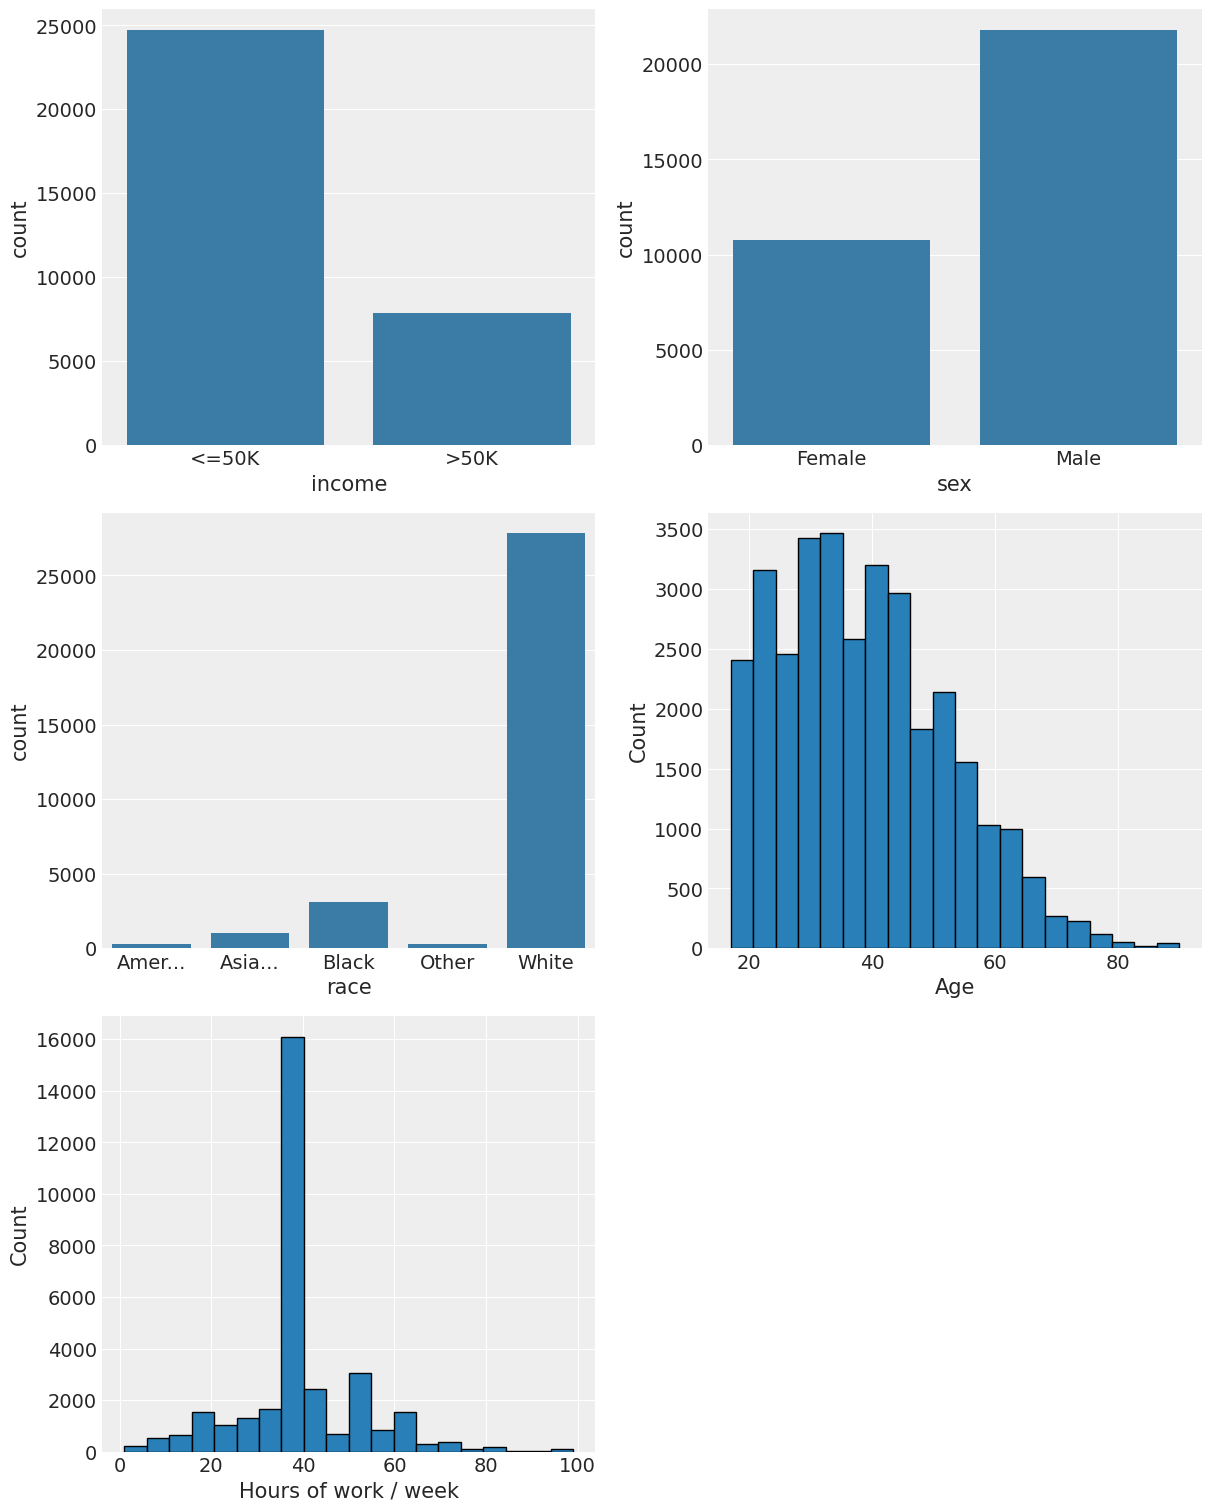

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color=BLUE, data=data, ax=axes[0, 0])
sns.countplot(x="sex", color=BLUE, data=data, ax=axes[0, 1]);
sns.countplot(x="race", color=BLUE, data=data, ax=axes[1, 0]);
axes[1, 0].set_xticklabels(truncate_labels(axes[1, 0].get_xticklabels()))
axes[1, 1].hist(data["age"], bins=20, edgecolor="black", color=BLUE);
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Count")
axes[2, 0].hist(data["hs_week"], bins=20, edgecolor="black", color=BLUE);
axes[2, 0].set_xlabel("Hours of work / week")
axes[2, 0].set_ylabel("Count")
axes[2, 1].axis('off');

**Highlights**

* Approximately 25% of the people make more than 50K a year.
* Two thirds of the subjects are males.
* The great majority of the subjects are white, only a minority are black and the other categories are very infrequent.
* The distribution of age is skewed to the right, as one might expect.
* The distribution of hours of work per week looks weird at first sight. But what is a typical workload per week? You got it, 40 hours :).

We only keep the races black and white to simplify the analysis. The other categories don't appear very often in our data. 

Now, we see the distribution of income for the different levels of our explanatory variables. Numerical variables are binned to make the analysis possible.

In [35]:
data = data[data["race"].isin(["Black", "White"])]
data["race"] = data["race"].cat.remove_unused_categories()
age_bins = [17, 25, 35, 45, 65, 90]
data["age_binned"] = pd.cut(data["age"], age_bins)
hours_bins = [0, 20, 40, 60, 100]
data["hs_week_binned"] = pd.cut(data["hs_week"], hours_bins) 

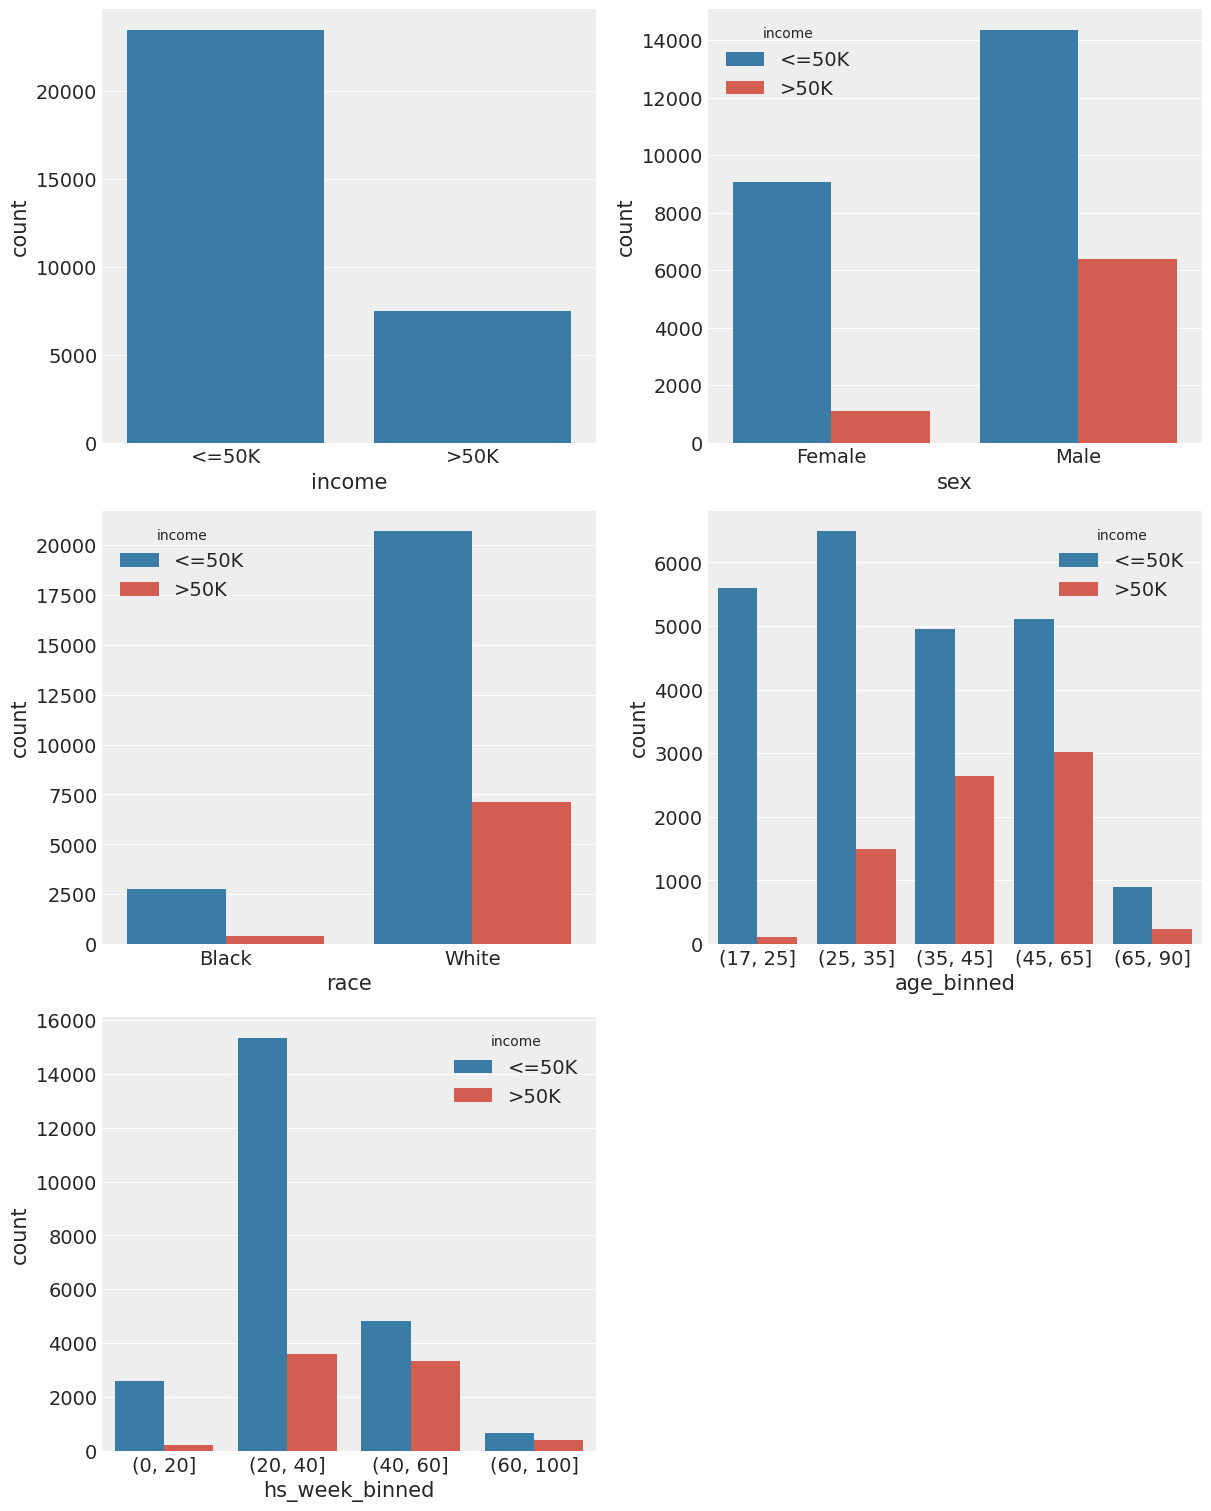

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color=BLUE, data=data, ax=axes[0, 0])
sns.countplot(x="sex", hue="income", palette=[BLUE, RED], data=data, ax=axes[0, 1]);
sns.countplot(x="race", hue="income", palette=[BLUE, RED], data=data, ax=axes[1, 0])
sns.countplot(x="age_binned", hue="income", palette=[BLUE, RED], data=data, ax=axes[1, 1])
sns.countplot(x="hs_week_binned", hue="income", palette=[BLUE, RED], data=data, ax=axes[2, 0])
axes[2, 1].axis('off');

Some data preparation before fitting our model. Here we standardize numerical variables **age** and **hs_week** because it may help sampler convergence. Also, we compute their second and third power. These powers will be sequantialy added to the model.

In [37]:
age_mean = np.mean(data["age"])
age_std = np.std(data["age"])
hs_mean = np.mean(data["hs_week"])
hs_std = np.std(data["hs_week"])

data["age"] = (data["age"] - age_mean) / age_std
data["age2"] = data["age"] ** 2
data["age3"] = data["age"] ** 3
data["hs_week"] = (data["hs_week"] - hs_mean) / hs_std
data["hs_week2"] = data["hs_week"] ** 2
data["hs_week3"] = data["hs_week"] ** 3

data = data.drop(columns=['age_binned', 'hs_week_binned'])

This is how our data looks like before fitting the models.

In [38]:
data.head()

,income,sex,race,age,hs_week,age2,age3,hs_week2,hs_week3
0,<=50K,Male,White,0.024207,-0.037250,0.000586,0.000014,0.001388,-0.000052
1,<=50K,Male,White,0.827984,-2.222326,0.685557,0.567630,4.938734,-10.975479
2,<=50K,Male,White,-0.048863,-0.037250,0.002388,-0.000117,0.001388,-0.000052
3,<=50K,Male,Black,1.047195,-0.037250,1.096618,1.148374,0.001388,-0.000052
4,<=50K,Female,Black,-0.779569,-0.037250,0.607728,-0.473766,0.001388,-0.000052


## The model

We will use a logistic regression model to estimate the probability of making more than 50K as a function of age, hours of work per week, sex, race and education level.

If we have a binary response variable $Y$ and a set of predictors or explanatory variables $X_1, X_2, \cdots, X_p$ the logistic regression model can be defined as follows:

$$\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p$$

where $\pi = P(Y = 1)$ (a.k.a. probability of success) and $\beta_0, \beta_1, \cdots \beta_p$ are unknown parameters. The term on the left side is the logarithm of the odds ratio or simply known as the log-odds. With little effort, the expression can be re-arranged to express our probability of interest, $\pi$, as a function of the betas and the predictors.

$$
\pi = \frac{e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}
    = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p)}}
$$

We need to specify a prior and a likelihood in order to draw samples from the posterior distribution. We could use sociological knowledge about the effects of age and education on income, but instead, let’s use the default prior specification in Bambi.

The likelihood is the product of $n$ Bernoulli trials, $\prod_{i=1}^{n}{p_i^y(1-p_i)^{1-y_i}}$ where $p_i = P(Y=1)$.  

In our case, we have 

$$Y = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person makes more than 50K per year} \\
        0 & \textrm{if the person makes less than 50K per year} 
    \end{array}
\right.
$$

$$\pi = P(Y=1)$$

But this is a Bambi example, right? Let's see how Bambi can helps us to build a logistic regression model.

## Model 1:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4   
$$

Where:

$
X_1 = \displaystyle \frac{\text{Age} - \text{Age}_{\text{mean}}}{\text{Age}_{\text{std}}} \\
X_2 = \displaystyle \frac{\text{Hours_week} - \text{Hours_week}_{\text{mean}}}{\text{Hours_week}_{\text{std}}} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is male} \\
        0 & \textrm{if the person is female} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. \\
$ 


In [39]:
model1 = bmb.Model(data)
fitted1 = model1.fit('income[>50K] ~ sex + race + age + hs_week',
                     family='bernoulli', draws=1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:259: UserWarning: Modeling the probability that income=='>50K'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hs_week, age, race, sex, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 68 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.633,0.062,-2.760,-2.525,0.002,0.001,1302.0,1298.0,1306.0,1128.0,1.0
sex,1.018,0.036,0.947,1.083,0.001,0.001,1687.0,1678.0,1726.0,1177.0,1.0
race,0.629,0.059,0.523,0.740,0.002,0.001,1417.0,1407.0,1419.0,1186.0,1.0
age,0.579,0.014,0.552,0.606,0.000,0.000,2612.0,2612.0,2615.0,1313.0,1.0
hs_week,0.504,0.016,0.472,0.531,0.000,0.000,2384.0,2384.0,2422.0,1099.0,1.0


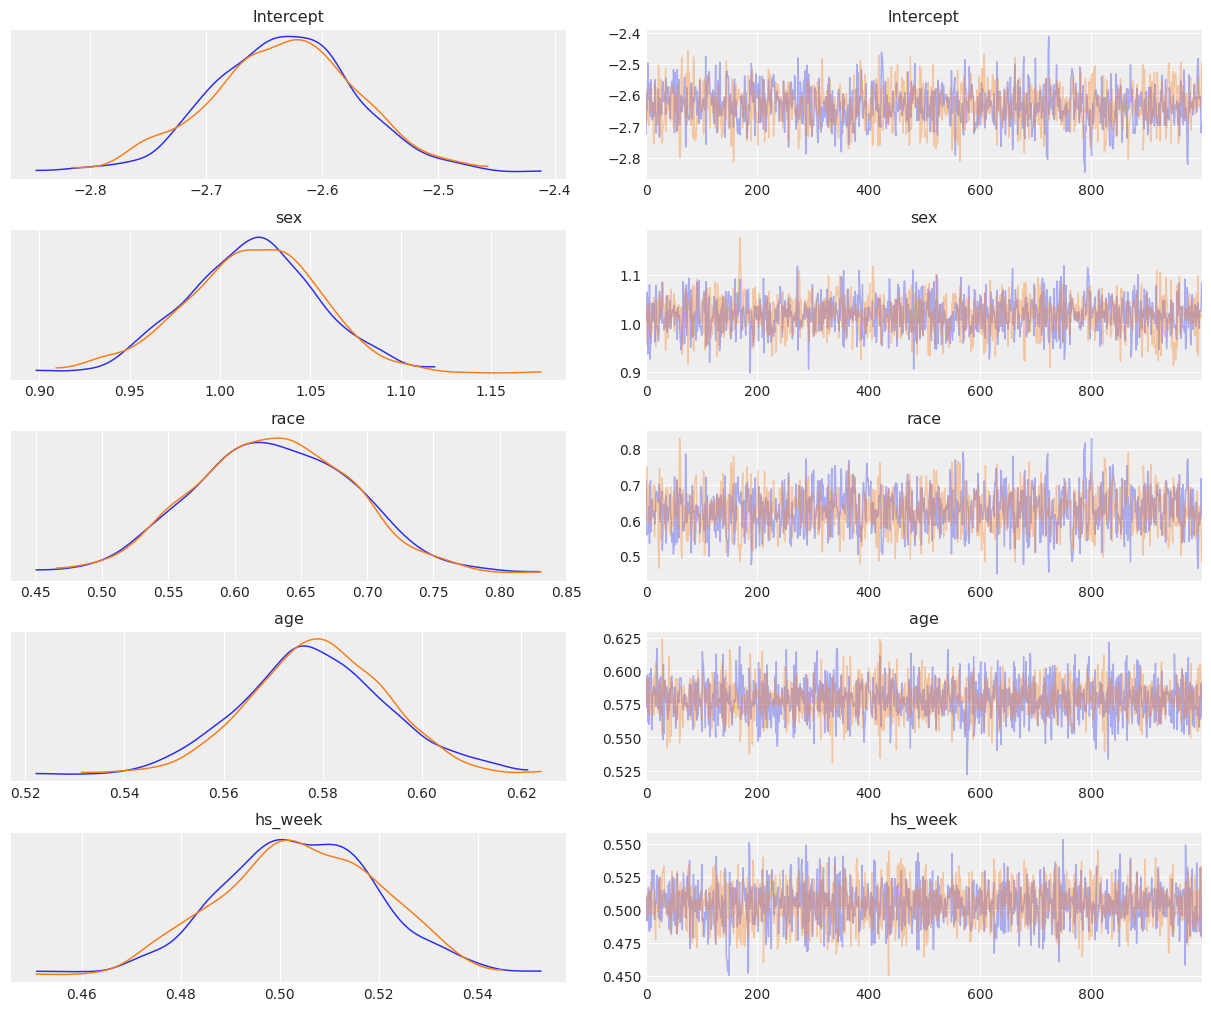

In [40]:
az.plot_trace(fitted1);
az.summary(fitted1)

## Model 2

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \beta_3 X_2 + \beta_4 X_2^2
                                         + \beta_5 X_3 + \beta_6 X_4
$$

Where: 

$
X_1 = \displaystyle \frac{\text{Age} - \text{Age}_{\text{mean}}}{\text{Age}_{\text{std}}} \\
X_2 = \displaystyle \frac{\text{Hours_week} - \text{Hours_week}_{\text{mean}}}{\text{Hours_week}_{\text{std}}} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is male} \\
        0 & \textrm{if the person is female} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. 
$

In [41]:
model2 = bmb.Model(data)
fitted2 = model2.fit('income[>50K] ~ sex + race + age + age2 + hs_week + hs_week2',
                     family='bernoulli', draws=1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:259: UserWarning: Modeling the probability that income=='>50K'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hs_week2, hs_week, age2, age, race, sex, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 82 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.283,0.063,-2.407,-2.171,0.002,0.001,1505.0,1505.0,1510.0,1071.0,1.0
sex,1.005,0.037,0.931,1.072,0.001,0.001,1714.0,1698.0,1688.0,1335.0,1.0
race,0.703,0.059,0.599,0.823,0.002,0.001,1521.0,1521.0,1523.0,1285.0,1.0
age,1.069,0.023,1.026,1.111,0.001,0.000,1544.0,1544.0,1546.0,1341.0,1.0
age2,-0.537,0.017,-0.569,-0.505,0.000,0.000,1493.0,1493.0,1495.0,995.0,1.0
hs_week,0.500,0.022,0.461,0.543,0.001,0.000,1387.0,1387.0,1382.0,1459.0,1.0
hs_week2,-0.088,0.009,-0.104,-0.072,0.000,0.000,1396.0,1396.0,1393.0,1101.0,1.0


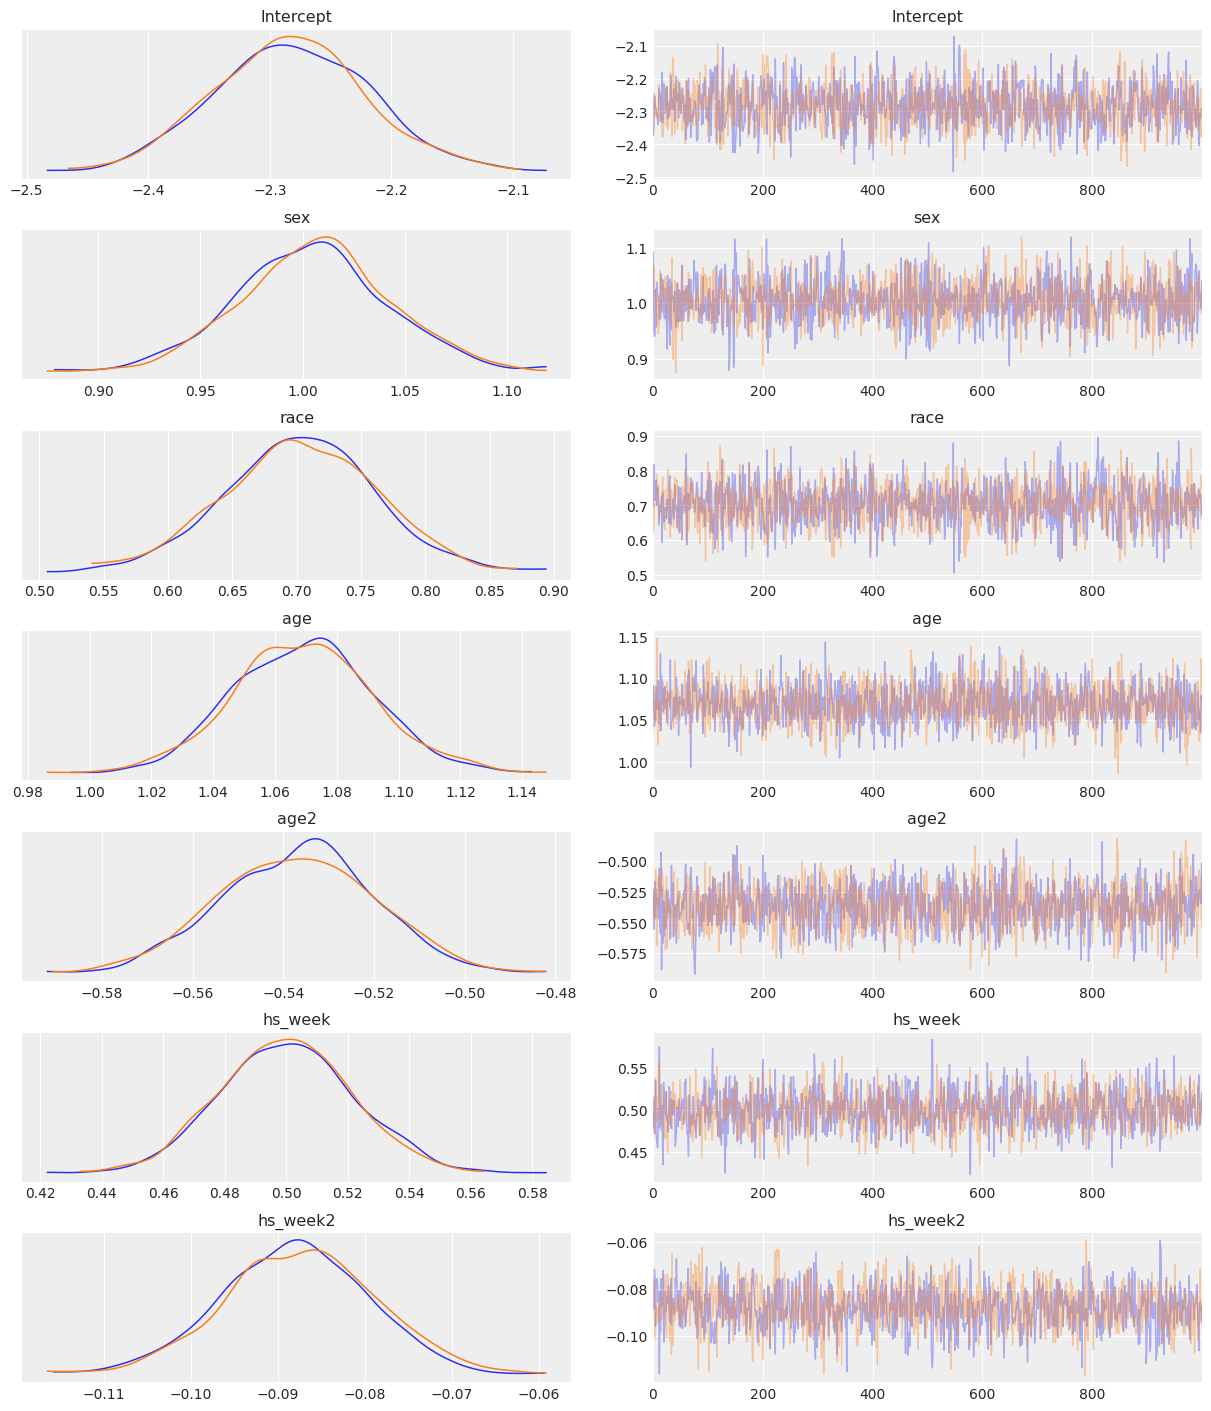

In [42]:
az.plot_trace(fitted2);
az.summary(fitted2)

## Model 3

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \beta_3 X_1^3 + \beta_4 X_2 
                                         + \beta_5 X_2^2 + \beta_6 X_2^3 + \beta_7 X_3 + \beta_8 X_4
$$

Where: 

$
X_1 = \displaystyle \frac{\text{Age} - \text{Age}_{\text{mean}}}{\text{Age}_{\text{std}}} \\
X_2 = \displaystyle \frac{\text{Hours_week} - \text{Hours_week}_{\text{mean}}}{\text{Hours_week}_{\text{std}}} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is male} \\
        0 & \textrm{if the person is female} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. 
$

In [43]:
model3 = bmb.Model(data)
fitted3 = model3.fit('income[>50K] ~ age + age2 + age3 + hs_week + hs_week2 + hs_week3 + sex + race',
                     family='bernoulli', draws=1000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:259: UserWarning: Modeling the probability that income=='>50K'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hs_week3, hs_week2, hs_week, age3, age2, age, race, sex, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 105 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.146,0.064,-2.259,-2.017,0.002,0.001,1486.0,1483.0,1490.0,1403.0,1.0
sex,0.986,0.037,0.922,1.060,0.001,0.001,1976.0,1969.0,1973.0,1254.0,1.0
race,0.680,0.060,0.569,0.793,0.001,0.001,1718.0,1699.0,1713.0,1329.0,1.0
age,0.963,0.026,0.912,1.011,0.001,0.000,2312.0,2311.0,2296.0,1303.0,1.0
age2,-0.894,0.031,-0.952,-0.837,0.001,0.001,1535.0,1535.0,1539.0,1236.0,1.0
age3,0.174,0.011,0.154,0.194,0.000,0.000,1623.0,1623.0,1637.0,1362.0,1.0
hs_week,0.612,0.025,0.565,0.657,0.001,0.000,1773.0,1766.0,1779.0,1503.0,1.0
hs_week2,-0.010,0.010,-0.029,0.009,0.000,0.000,1883.0,1498.0,1881.0,1456.0,1.0
hs_week3,-0.035,0.004,-0.042,-0.029,0.000,0.000,1457.0,1437.0,1471.0,1440.0,1.0


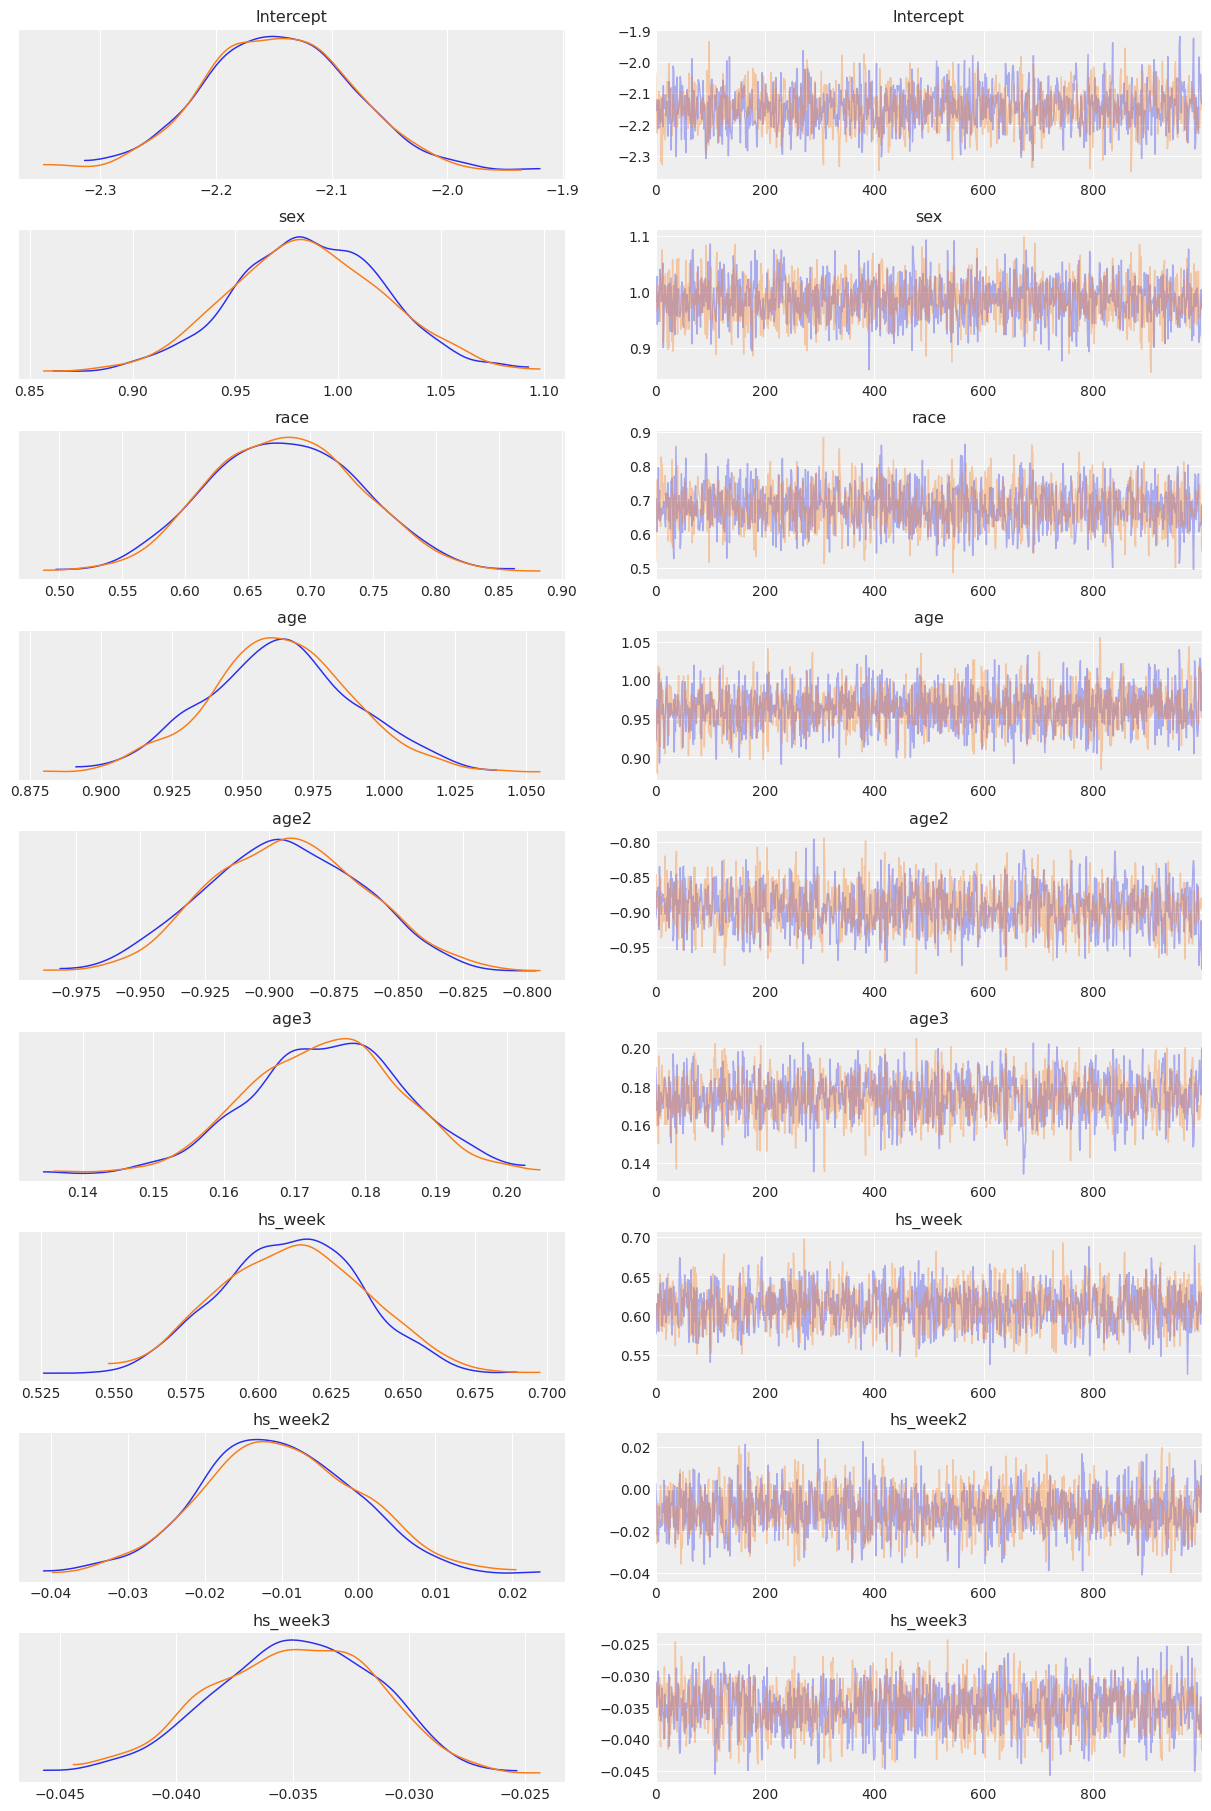

In [44]:
az.plot_trace(fitted3);
az.summary(fitted3)

## Model comparison

We can perform a Bayesian model comparison very easily with `az.compare()`. Here we pass a dictionary with the InferenceData objects that `Model.fit()` returned and `az.compare()` returns a data frame that is ordered from best to worst according to the criteria used. By default, ArviZ uses *loo*,  which is an estimation of leave one out cross validation. Another option is the widely applicable information criterion (WAIC). For more information about the information criterias available and other options within the function [see the docs](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html).

In [45]:
models_dict = {
    "model1": fitted1,
    "model2": fitted2,
    "model3": fitted3
}
df_compare = az.compare(models_dict)
df_compare

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:144: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-13987,9.46067,0,1,89.3116,0,False,log
model2,1,-14154.9,7.99789,167.978,0,91.3183,19.838,False,log
model1,2,-14915.9,4.95586,928.967,0,90.9912,38.9146,False,log


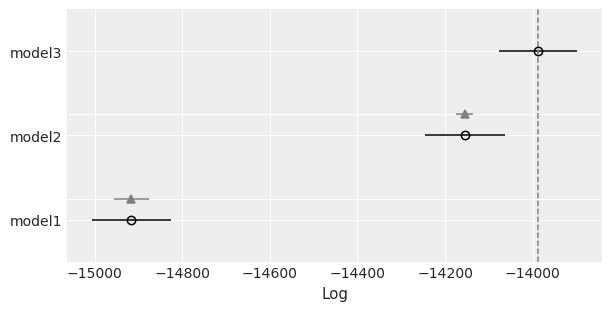

In [46]:
az.plot_compare(df_compare, insample_dev=False);

There is a difference in the point estimations (empty circles) between the model with cubic terms (model 3) and the model with quadratic terms (model 2) but there is some overlap between their interval estimations. This time, we are going to select model 2 and do some extra little work with it because from previous experience with this dataset we know there is no substantial difference between them, and model 2 is simpler. However, as we mention in the final remarks, this is not the best you can achieve with this dataset. If you want, you could also try to add other predictors, such as education level and see how it impacts in the model comparison :). 

## Probability estimation

In this section we plot age vs the probability of making more than 50K a year given different profiles.

In [20]:
posterior = fitted2.posterior.stack({"draws":["chain", "draw"]})

We set hours of work per week at 40 hours and assign a grid from 18 to 75 age. They're standardized because they
were standardized when we fitted the model.

In [21]:
HS_WEEK = (40 - hs_mean) / hs_std
AGE = (np.linspace(18, 75) - age_mean) / age_std
AGE = AGE[:, None]

Now we compute the intercepts for the four combinations between sex and race.

In [22]:
int_fem_black = posterior['Intercept']
int_mal_black = int_fem_black + posterior['sex']
int_fem_white = int_fem_black + posterior['race']
int_mal_white = int_mal_black + posterior['race']

The contribution of hours of work per week.

In [23]:
hs_contr = HS_WEEK * posterior['hs_week'].values[None,:]
hs_contr += HS_WEEK ** 2 * posterior['hs_week2'].values[None,:]

And the linear predictor for all the ages in the grid.

In [24]:
age_contr = np.dot(AGE, posterior['age'].values[None,:])
age_contr += np.dot(AGE ** 2, posterior['age2'].values[None,:])

Then we just store all the linear predictors in a list called `eta`.

In [25]:
eta_base = hs_contr + age_contr
eta_fem_black = np.expand_dims(int_fem_black, axis=-1).T + eta_base
eta_mal_black = np.expand_dims(int_mal_black, axis=-1).T + eta_base
eta_fem_white = np.expand_dims(int_fem_white, axis=-1).T + eta_base
eta_mal_white = np.expand_dims(int_mal_white, axis=-1).T + eta_base

etas = [eta_fem_black, eta_mal_black, eta_fem_white, eta_mal_white]
age = AGE * age_std + age_mean

And finally, the plot :)

Here we use `az.plot_hdi()` to get Highest Density Interval plots. We get two bands for each profile. One corresponds to an hdi probability of 0.94 (the default) and the other to an hdi probability of 0.5.

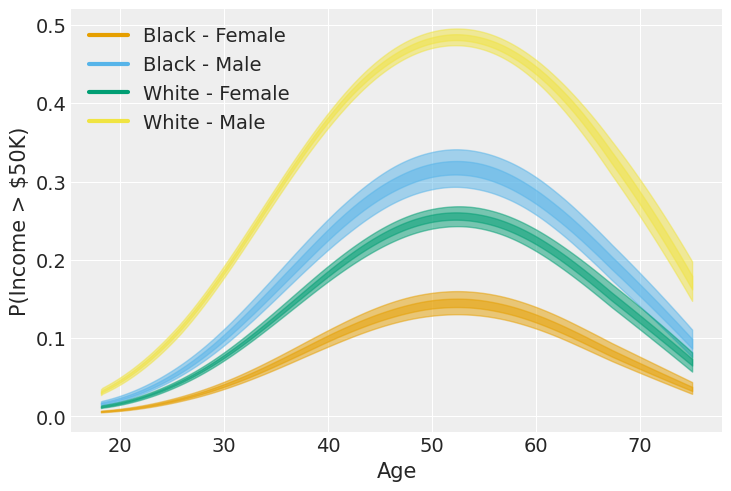

In [26]:
colors = ["#E69F00", "#56B4E9", "#009E73" ,"#F0E442"]
labels = ["Black - Female", "Black - Male", "White - Female", "White - Male"]
handles = []

fig, ax = plt.subplots()

for eta, color, label in zip(etas, colors, labels):
    az.plot_hdi(age[:,0], invlogit(eta).T, ax=ax, color=color)
    az.plot_hdi(age[:,0], invlogit(eta).T, ax=ax, color=color, hdi_prob=0.5)
    handles.append(mlines.Line2D([], [], color=color, label=label, lw=3)) 
    
ax.set_xlabel("Age")
ax.set_ylabel("P(Income > $50K)")
ax.legend(handles=handles, loc="upper left");    

The highest posterior density bands show how the probability of earning more than 50K changes with age for a given profile. In all the cases, we see the probability of making more than $50K increases with age until approximately age 52, when the probability begins to drop off. We can interpret narrow portions of a curve as places where we have low uncertainty and spread out portions of the bands as places where we have somewhat higher uncertainty about our coefficient values.

### Final remarks

In this notebook we've seen how easy it is to incorporate ArviZ into a Bambi workflow to perform model comparison based on information criterias such as **LOO** and **WAIC**. However, an attentive reader might have seen that the highest density interval plot never shows a predicted probability greater than 0.5 (which is not good if we expect to predict that at least some people working 40hrs/wk make more tha \$50k/yr). You can increase the hours of work per week for the profiles we've used and the HDIs will show larger values. But that's not the bigger issue.  

Although we're using some demographic variables such as **sex** and **race**, the cells resulting from the combinations of their levels are still very heterogeneous. For example, we are mixing individuals of all educational levels. A possible next step is to **incorporate education** into the different models we compared. If any of the readers (yes, you!) is interested in doing so, here there are some notes that may help 

* Education is an ordinal categorical variable with a lot of levels. 
    + Explore the conditional distribution of income given education levels.
    + See what are the counts/proportions of people within each education level.
    + Collapse categories (but respect the ordinality!). Try to end up with 5 or less categories if possible.
* Start with a model with only **age**, **sex**, **race**, **hs_week** and **education**. Then incorporate higher order  terms (second and third powers for example). Don't go beyond fourth powers.
* Look for a nice activity to do while the sampler does its job.  
We know it's going to take a couple of hours to fit all those models :) 

And finally, please feel free to [open a new issue](https://github.com/bambinos/bambi/issues) if you think there's something that we can improve.

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz   0.10.0
numpy   1.19.1
seaborn 0.10.1
bambi   0.2.0
pandas  1.1.1
last updated: Wed Nov 11 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
